# Synchornization in complete networks of neurons
Here is the dynamics of neurons potentails in rotational model :
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) +  E \\
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
num_neurons = 10000
g = 5
random_input_span = (3.5,13.5) #it should fall in the well defined cos(\theta) domain.

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

theta_arr = np.zeros(num_neurons,dtype = float)
# theta_arr = np.random.uniform(0,2*np.pi,size = num_neurons)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )
amin_saman_param = np.zeros( total_steps )

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [4]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

In [5]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0


## "For" loop on the march!
To make equations more solvable we turn them into three cases of linear first order equations:
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) - g E \\
\dot{E} = M - \alpha E\\
\dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [6]:
for i in tqdm( range(total_steps - 1) ):
    theta_arr = theta_arr + (random_input - np.cos(theta_arr) - g * e_arr[i] )*time_step
    
    #here we should spot the spiking neurons.
    spiking_records[i] = theta_arr > np.pi
    theta_arr = theta_arr - 2 * np.pi * spiking_records[i]
#     theta_arr = theta_arr + 2 * np.pi * (theta_arr < - np.pi)
    #neurons activity
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )
    #
    left_handed_neurons = np.cos(theta_arr) < 0
    amin_saman_param[i] = np.mean( np.sin(theta_arr[left_handed_neurons]) )**2
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones
    
    

  0%|                                                                                        | 0/99999 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:52<00:00, 1896.98it/s]


In [7]:
sigma = np.std( e_arr )
sigma

0.03454035036840852

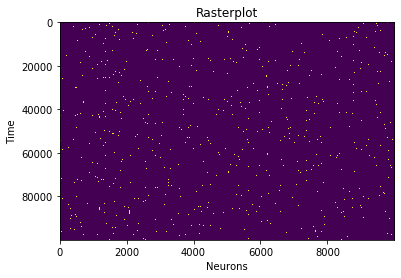

In [8]:
plt.imshow( spiking_records, aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig('raster_plot/raster_plot_N{}_g{}.png'.format(num_neurons,g))

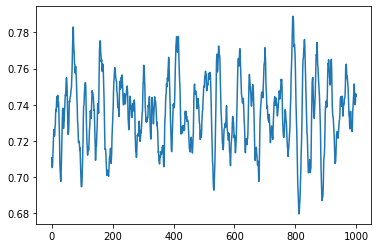

In [9]:
plt.plot(e_arr[-1000:])

In [10]:
random_input - g *e_arr[-1] 

array([6.0978486 , 2.31848346, 5.17215856, ..., 4.84421371, 1.90472564,
       4.68798441])

(array([ 668.,  729., 1368., 1436., 1394., 1189., 1010.,  812.,  727.,
         667.]),
 array([-3.14125509e+00, -2.51306756e+00, -1.88488003e+00, -1.25669250e+00,
        -6.28504974e-01, -3.17445716e-04,  6.27870082e-01,  1.25605761e+00,
         1.88424514e+00,  2.51243267e+00,  3.14062019e+00]),
 <a list of 10 Patch objects>)

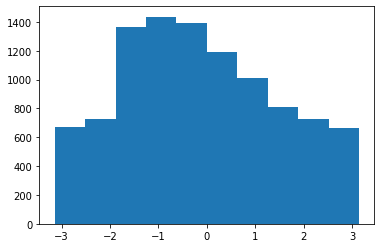

In [11]:
plt.hist(theta_arr )

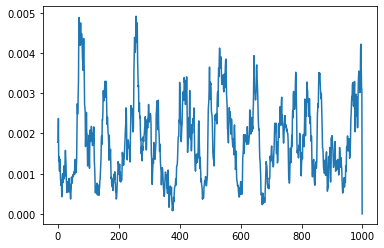

In [12]:
plt.plot(amin_saman_param[-1000:])

In [13]:
np.mean(amin_saman_param[-100:])

0.0019034158958493614

## Calculate frequnecy

In [14]:
spikies_period_mean = total_spikes_intervals * time_step / total_spikes_num
spikies_period_mean

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([1.02593782, 2.91759531, 1.21604908, ..., 1.30164042, 3.73265918,
       1.34692935])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8.814e+03, 1.080e+02, 3.100e+01, 5.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.63288746,  11.38759871,  22.14230997,  32.89702122,
         43.65173248,  54.40644373,  65.16115498,  75.91586624,
         86.67057749,  97.42528875, 108.18      ]),
 <a list of 10 Patch objects>)

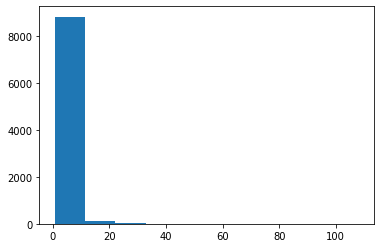

In [15]:
plt.hist(spikies_period_mean)

In [16]:
heights, bins = np.histogram(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
# plt.scatter(bins[:-1],heights)
# plt.yscale('log')
# plt.xscale('log')
heights, bins

(array([   0,    0,    0,    0,    0,    0,    0,  854, 1840, 1474, 1152,
         920,  720,  540,  382,  346,  253,  175,  116], dtype=int64),
 array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
         0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
         1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
         3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ]))

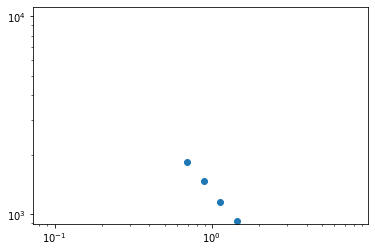

In [17]:
plt.scatter(bins[:-1],heights)
plt.yscale('log')
plt.xscale('log')

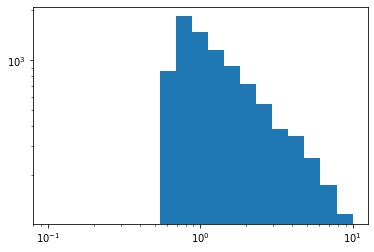

In [18]:
(heights, bins, patches) = plt.hist(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
plt.yscale('log')
plt.xscale('log')

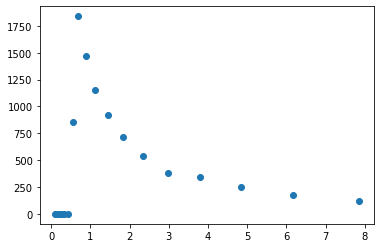

In [19]:
plt.scatter(bins[:-1],heights)
# plt.yscale('log')
# plt.xscale('log')
plt.savefig('spikies_time_interval/spikies_time_interval_N{}_g{}'.format(num_neurons,g))